<a href="https://colab.research.google.com/github/kolikaran1992/ml_algos/blob/main/Loess_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass, field
import typing

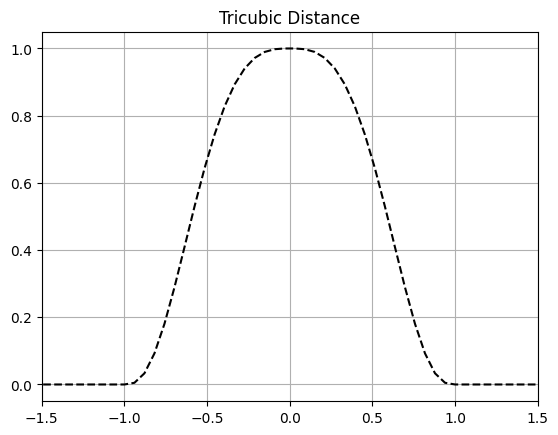

In [2]:
def tricubic_weight(ref_point: float, other_points: np.array) -> np.array:
    """
    - calculates tricubic weight between ref_point and all the real numbers
      present in other_points
    NOTE:
        edge cases like max distance bet ref_point and other_pionts being zero
        have not been handled in this implementation
    """

    ref_minus_others = np.abs(ref_point - other_points)
    dists = (1 - (ref_minus_others/max(ref_minus_others))**3)**3
    return dists

def tricubic_function(x: np.array) -> np.array:
    """
    - tricubic distance implementation on real numbers
    """
    # numbers outside -1, 1 range will have 0 weight
    map_ = np.where((x <= 1) & (x >= -1), 1, 0)
    dists = (1-np.abs(x)**3)**3
    return map_*dists

x_ = np.linspace(-3,3,100)
plt.plot(x_, tricubic_function(x_), ls = '--', color='black')
plt.title('Tricubic Distance')
plt.grid()
plt.xlim([-1.5,1.5])
plt.show()

# PREPARE DATA

**DATA DESCRIPTION**

Let $\{(x_i,y_i); i \in [1,n] \}$ be the data points such that the independent variables are ordered. This ordering could be in terms of distance b/w the indepent variables or it could also be the time at which the observation was taken

In [3]:
n = 200
x = np.linspace(0,np.pi*10,n)
# x = x + np.random.normal(0,0.1,n)
y = np.sin(x) + np.random.normal(0,0.2,n)

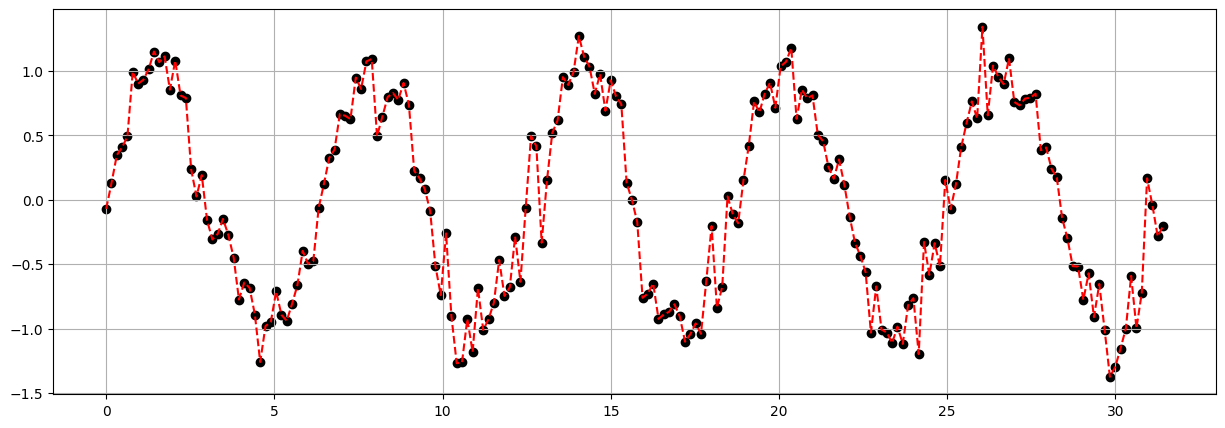

In [4]:
plt.figure(figsize=(15,5))
plt.plot(x,y, ls='--', color='red')
plt.scatter(x,y, marker='o', color='black')
plt.grid()
plt.show()

# LOESS REGRESSION

[stat quest video](https://www.youtube.com/watch?v=Vf7oJ6z2LCc&ab_channel=StatQuestwithJoshStarmer)



## STEPS
1. start from the first value of the independent variable (independent points are ordered)
2. define a window_size = r, find r points with least euclidean distance for the first point
3. perform weighted regression on all the points in the window
    1.  the point where the regression line intersects the independent variable is the point on the loess curve

In [5]:
@dataclass
class SingleWindowRegression:
    """
    - Implements weighted regression in a single window of the Loess Regression
    """
    params: np.array = field(init=False, default=None)

    def _prepare_X(self, X: np.array) -> np.array:
        """
        - does the following
          1. makes the array column array if it is not already a column array
          2. attaches array of ones for the intercept term
        """
        if len(X.shape) == 1:
            X = X.reshape(-1,1)

        X = np.c_[np.ones((len(X),1)), X]
        return X

    def _prepare_vars(self, X: np.array, y: np.array, weights: np.array) -> typing.Tuple[np.array, np.array, np.array]:
        """
        - post processes X,y and weights so thatthey can be used in normal equation of the
          regression
        """
        X = self._prepare_X(X)
        W = np.diag(weights)

        y = y.reshape(-1,1)

        return X, y, W

    def fit(self, X: np.array, y: np.array, weights: np.array) -> None:
        """
        - y = b^TX
          b = (X^TWX)^(-1)X^TWY
        """
        X, y, W = self._prepare_vars(X, y, weights)
        XtW = np.matmul(X.T, W)
        b = np.matmul(
                np.linalg.inv(np.matmul(XtW, X)),
                np.matmul(XtW, y)
                )
        self.params = b

    def transform(self, X: np.array) -> None:
        """
        - returns predicted value of Y
        """
        X = self._prepare_X(X)
        return np.matmul(X, self.params)


@dataclass
class LoessRegression:
    """
    - Implements loess regression
    """
    X: np.array = field(init=True)
    y: np.array = field(init=True)
    window_size: int = field(init=True, default = 5)

    window_regressors: typing.List[SingleWindowRegression] = field(init=False, default_factory=list)
    window_idxs: np.array = field(init=False)

    def __post_init__(self) -> None:
        self._init_window_idxs()

    def _init_window_idxs(self) -> np.array:
        """
        - returns a window mapping numpy array, d, such that d[i] will have
          window_size number of indices relative to X of least distances from
          X[i]
        """
        X = self.X.copy()
        if len(X.shape) == 1:
            X = X.reshape(-1,1)

        window_idxs = np.sqrt(np.sum((X - np.expand_dims(X, axis=1))**2, axis=2)).argsort()[:, :self.window_size]
        self.window_idxs = window_idxs

    def fit(self) -> np.array:
        assert self.window_size <= len(self.X), f'the window size ({self.window_size}) must be smaller than length of input array ({len(X)})'
        pairs = []
        transformed_y = []
        for ref_point, window_idxs in zip(self.X, self.window_idxs):
            regressor = SingleWindowRegression()
            weights = tricubic_weight(ref_point, self.X[window_idxs])
            regressor.fit(self.X[window_idxs], self.y[window_idxs], weights)
            self.window_regressors.append(regressor)
            pairs.append((window_idxs, regressor.transform(self.X[window_idxs]).reshape(-1)))
            transformed_y.append(regressor.transform(np.array([ref_point]))[0][0])

        return pairs, transformed_y

In [6]:
loess_reg = LoessRegression(x, y, 20)
%time pairs, transformed_y = loess_reg.fit()

CPU times: user 63.9 ms, sys: 73.1 ms, total: 137 ms
Wall time: 115 ms


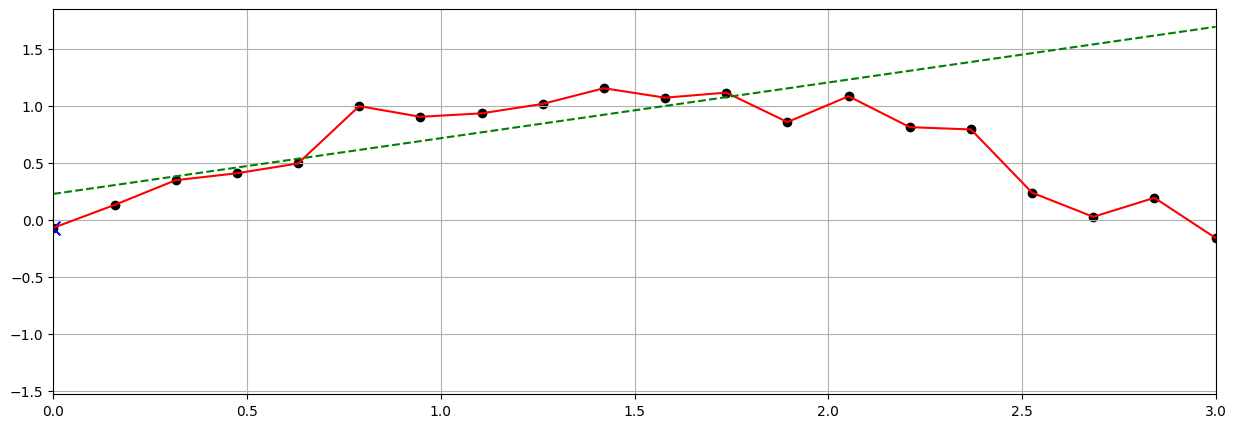

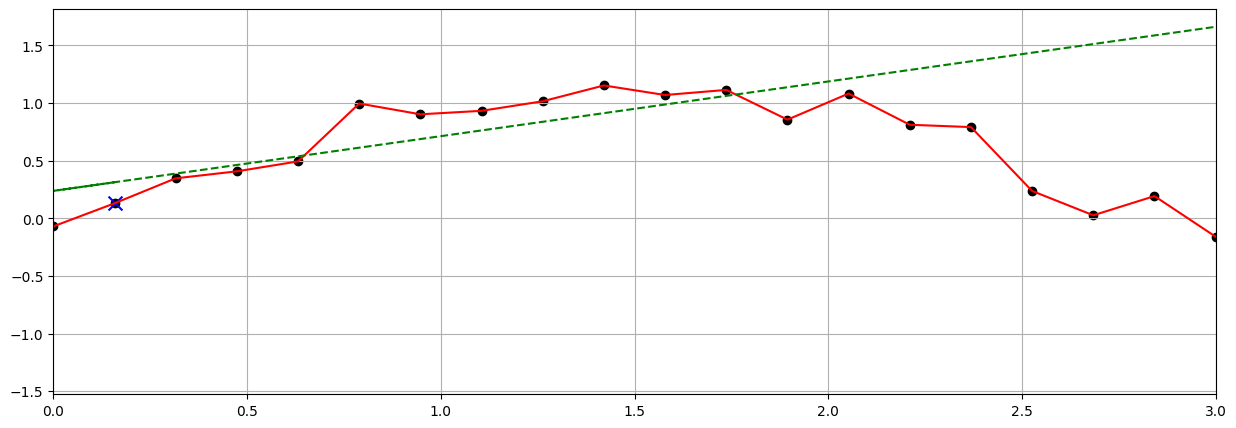

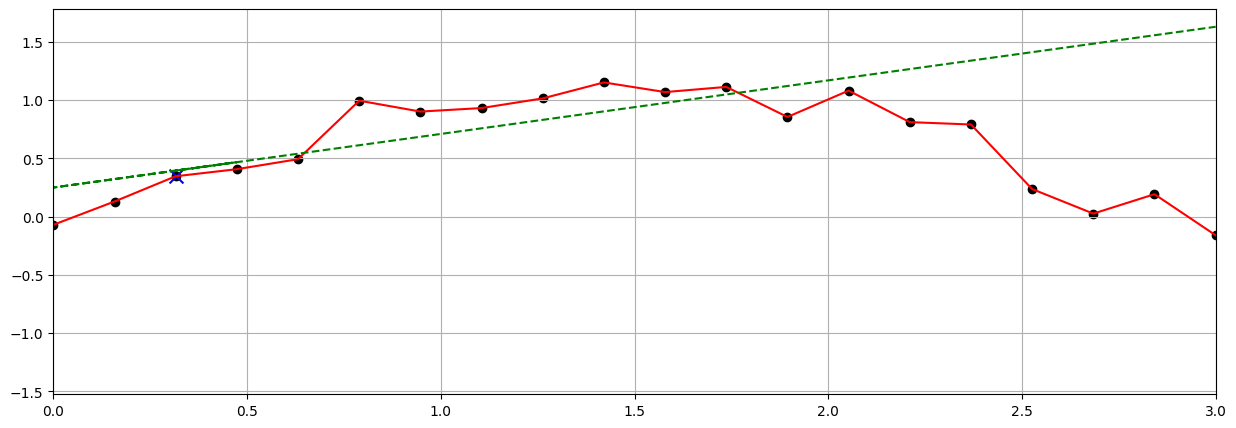

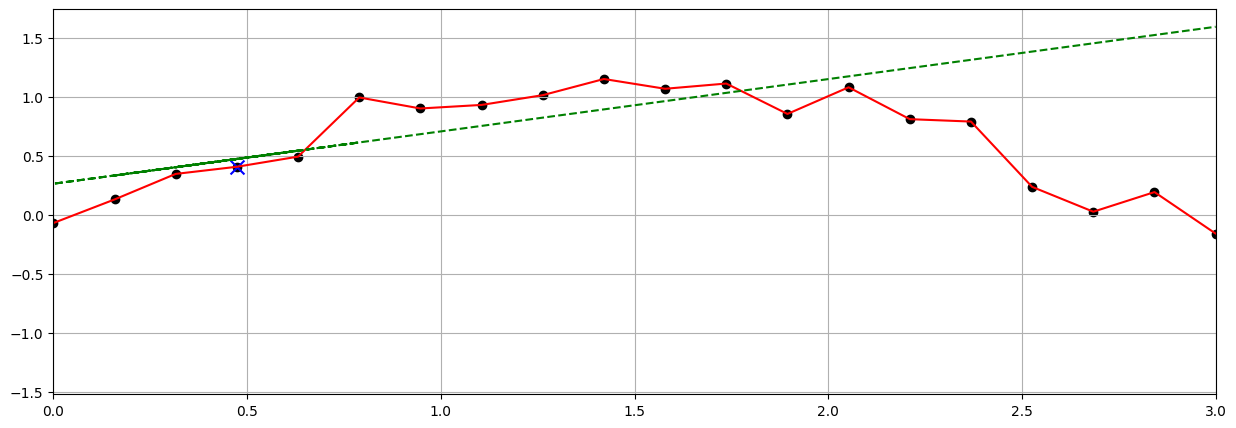

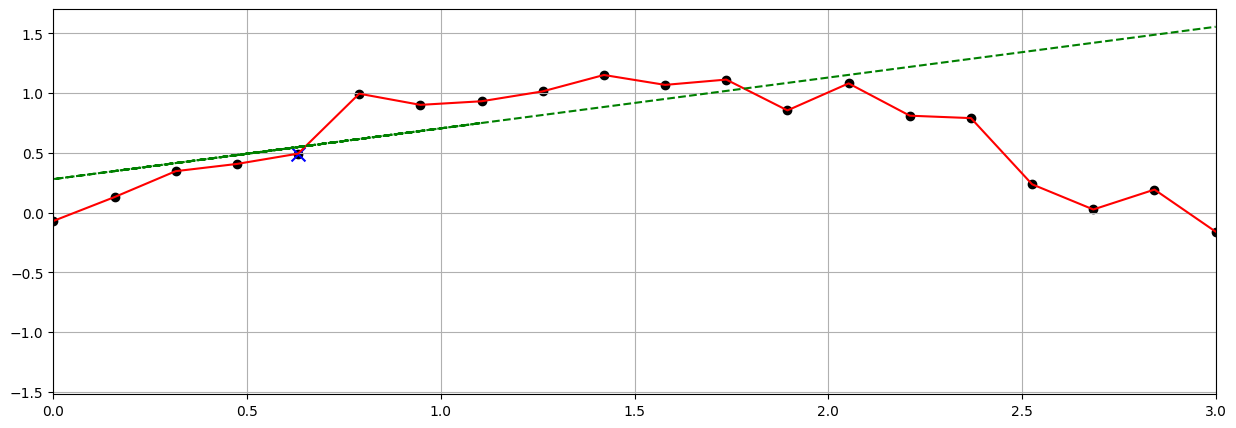

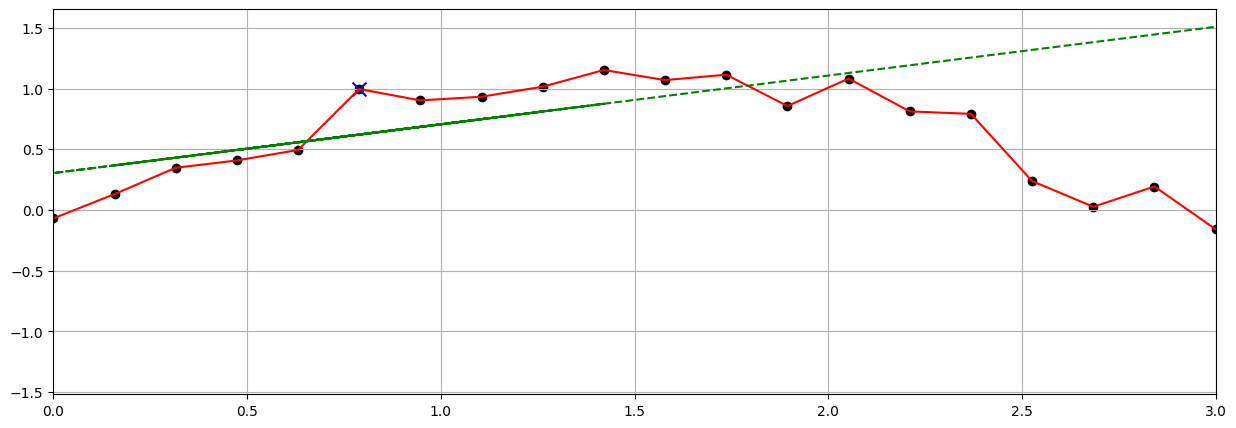

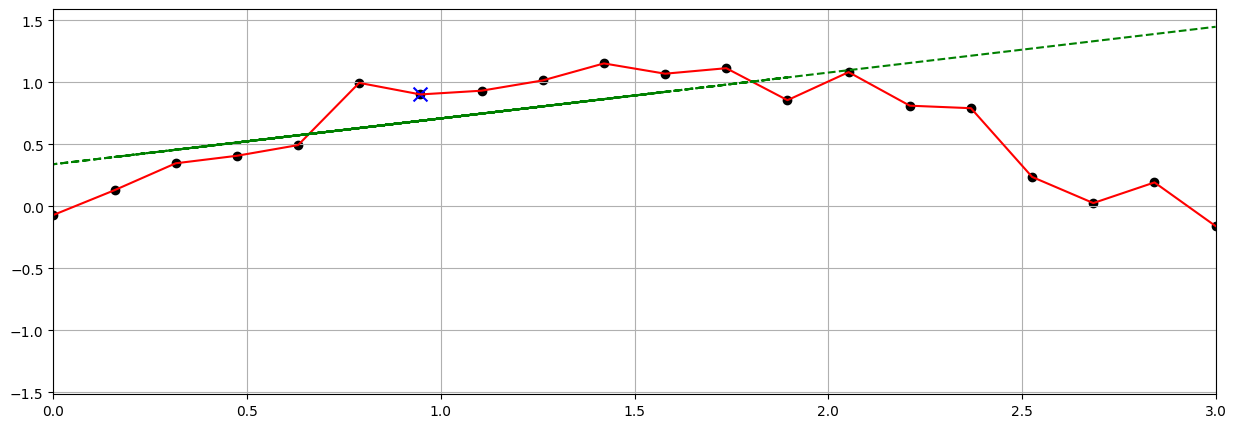

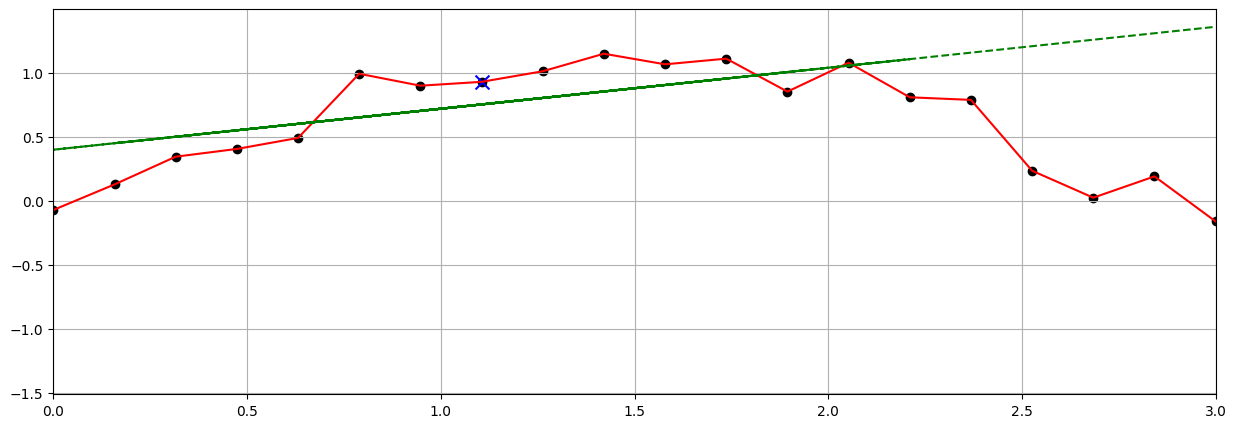

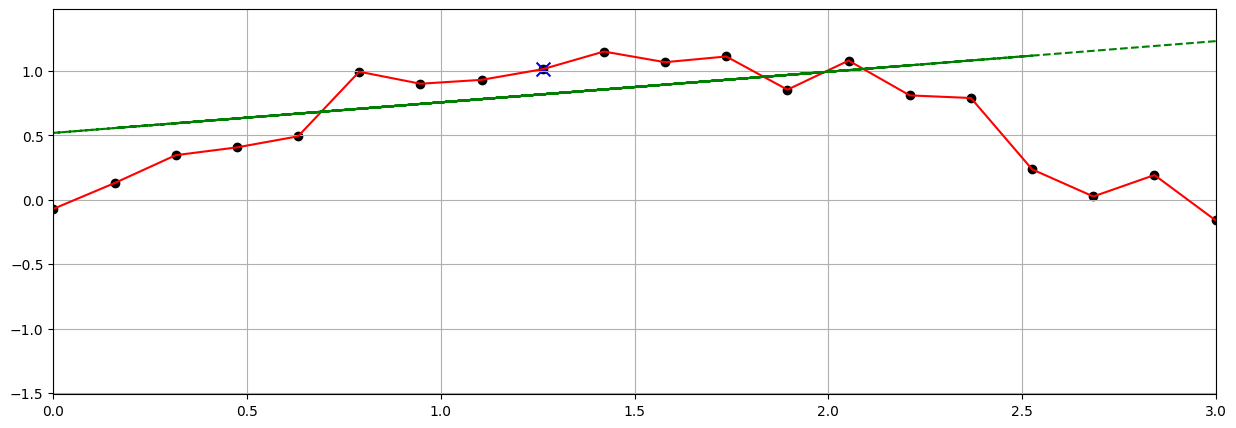

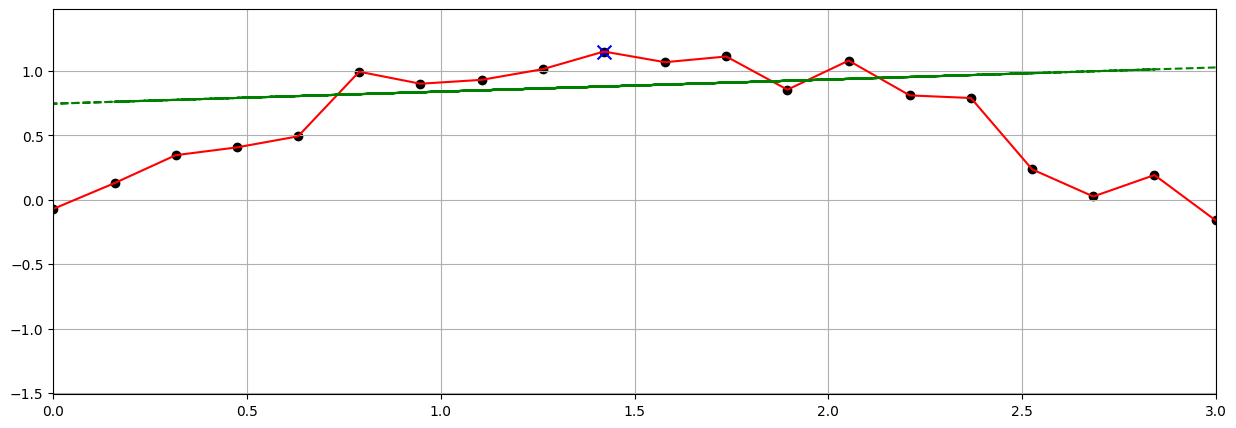

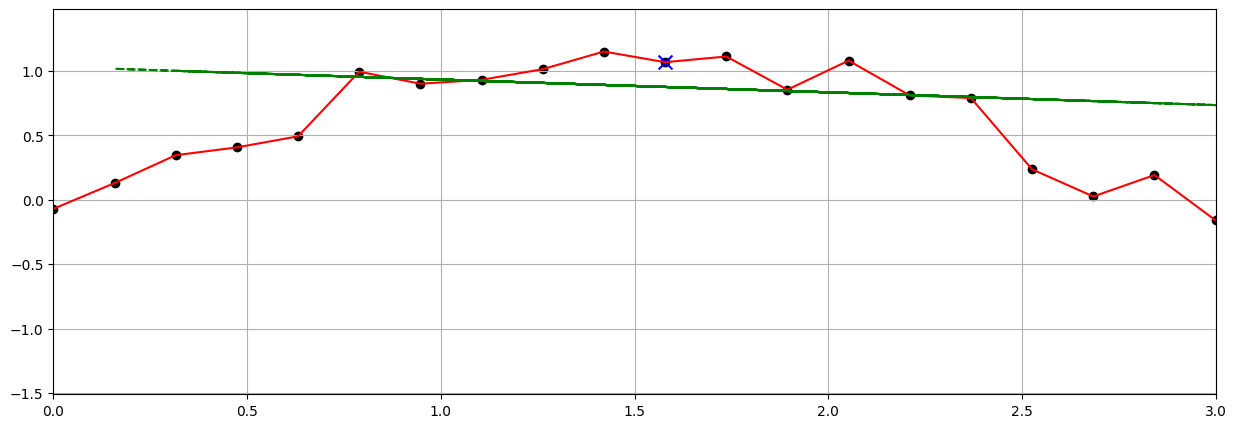

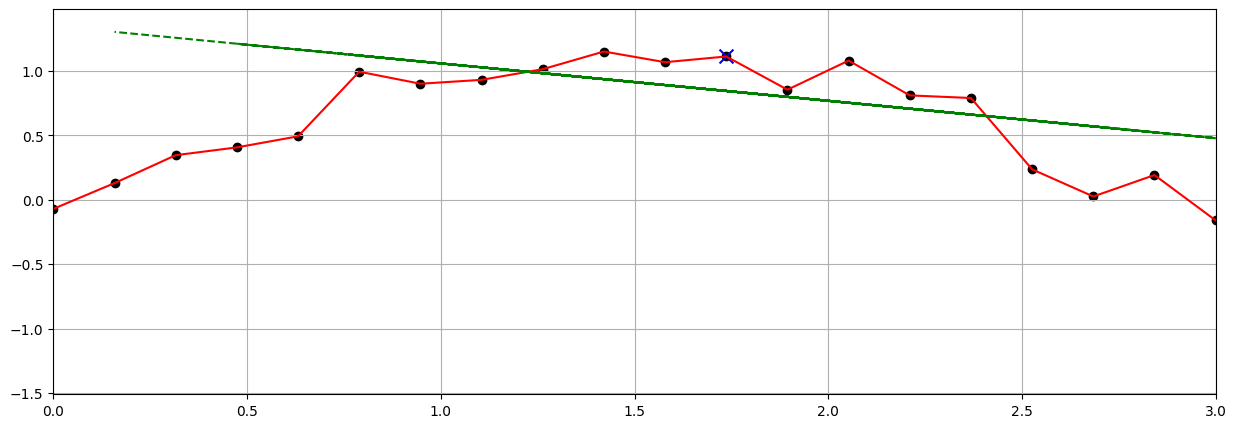

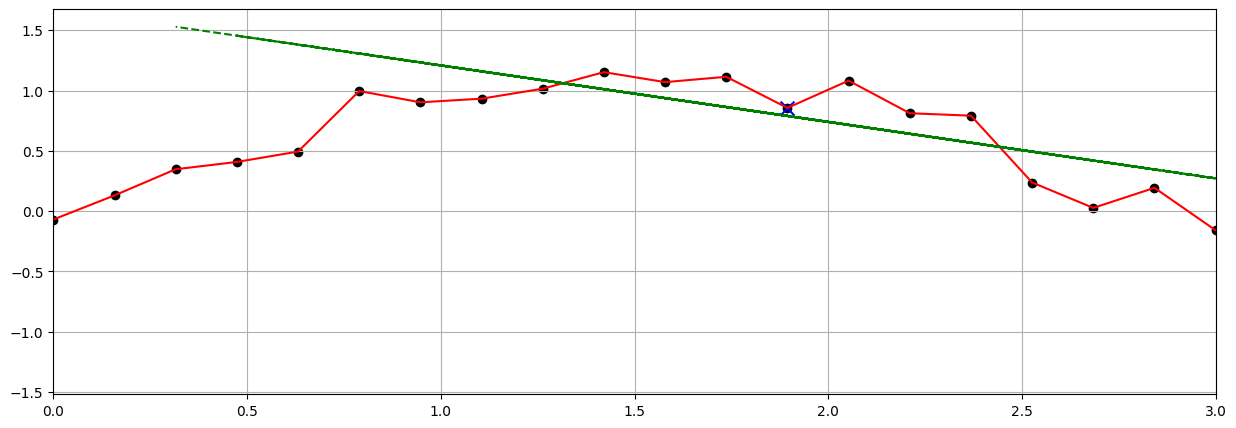

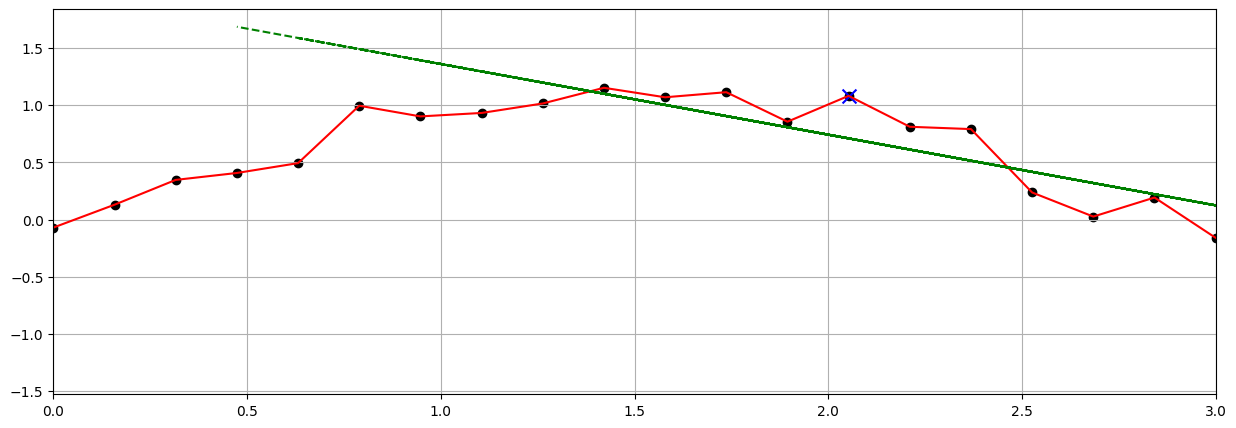

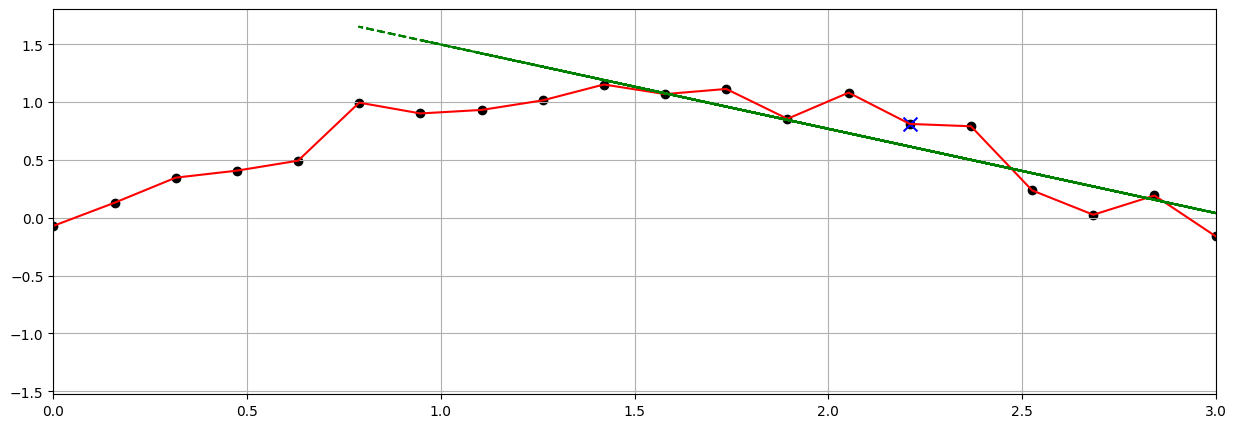

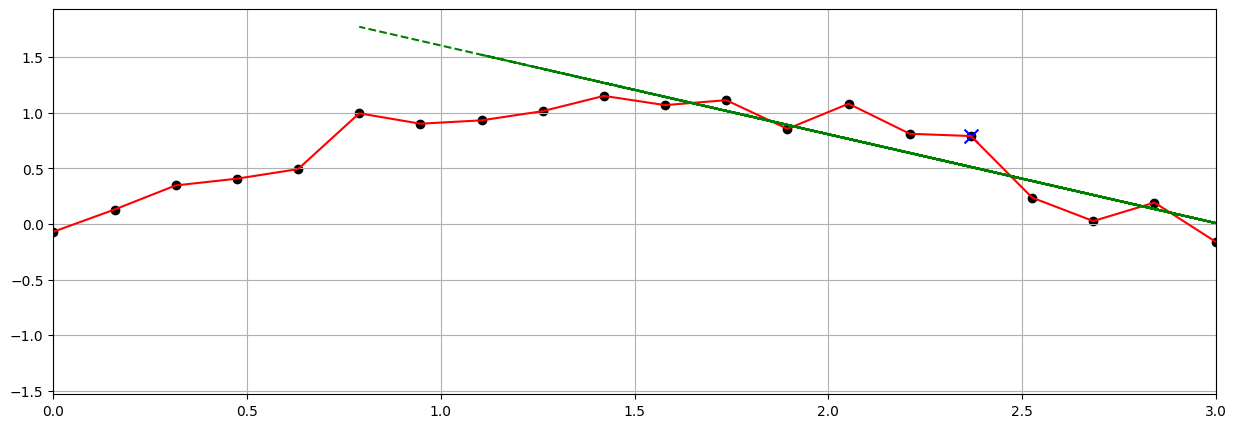

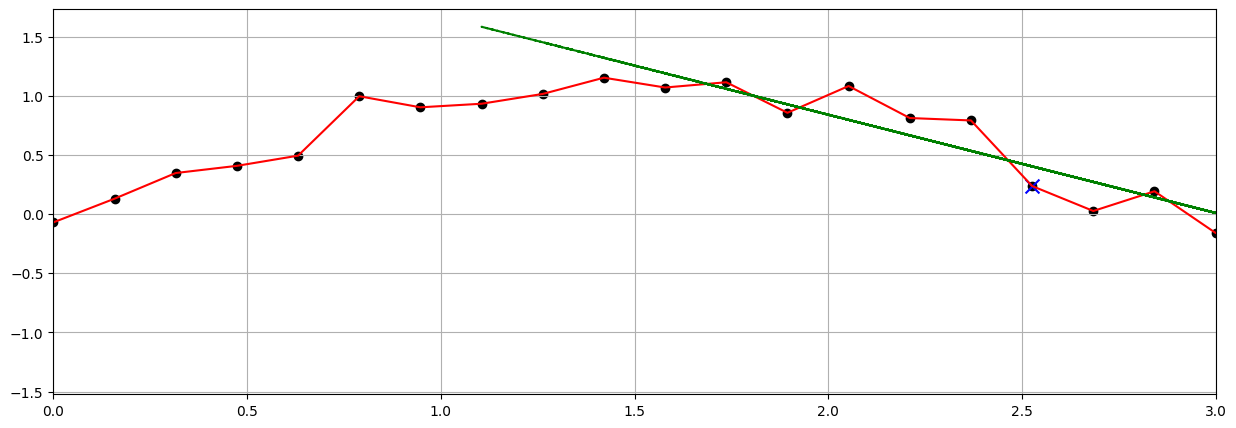

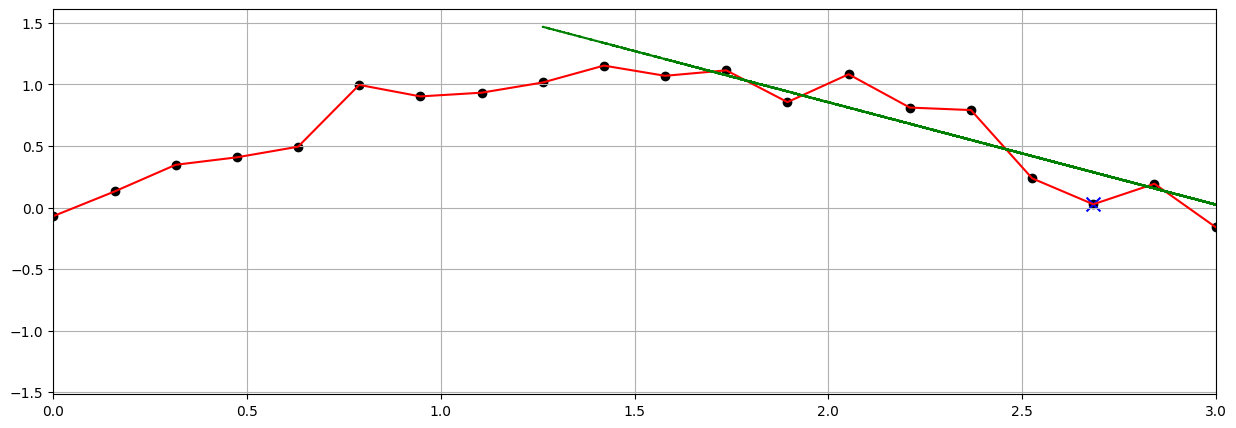

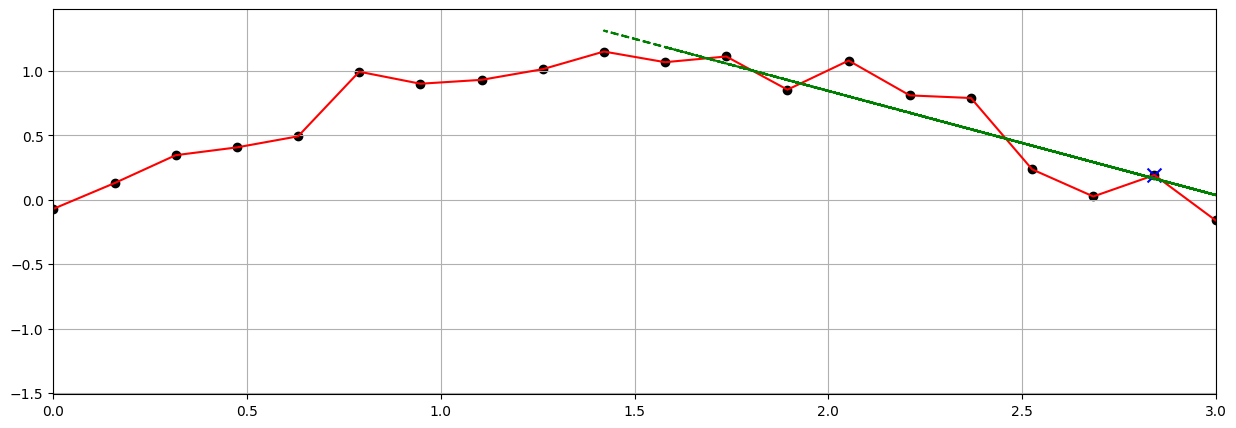

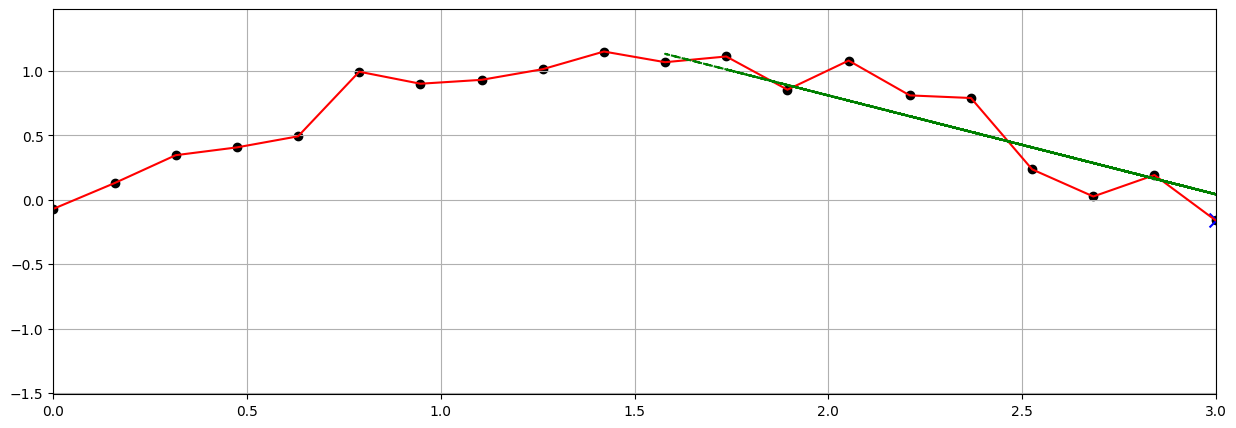

In [7]:
for show_idx in range(20):
    plt.figure(figsize=(15,5))
    plt.plot(x,y, ls='-', color='red')
    plt.scatter(x,y, marker='o', color='black')
    plt.grid()


    # show_idx = 10
    for x_, y_ in pairs[show_idx:show_idx+1]:
        plt.plot(x[x_], y_, ls='--', color='green')
        # plt.scatter(x[x_], y[x_], marker='x', color='blue')
        plt.scatter(x[show_idx:show_idx+1], y[show_idx:show_idx+1], marker='x', color='blue', s=100)

    plt.xlim([0,3])
    plt.show()

In [ ]:
# transformed_y[0:10]

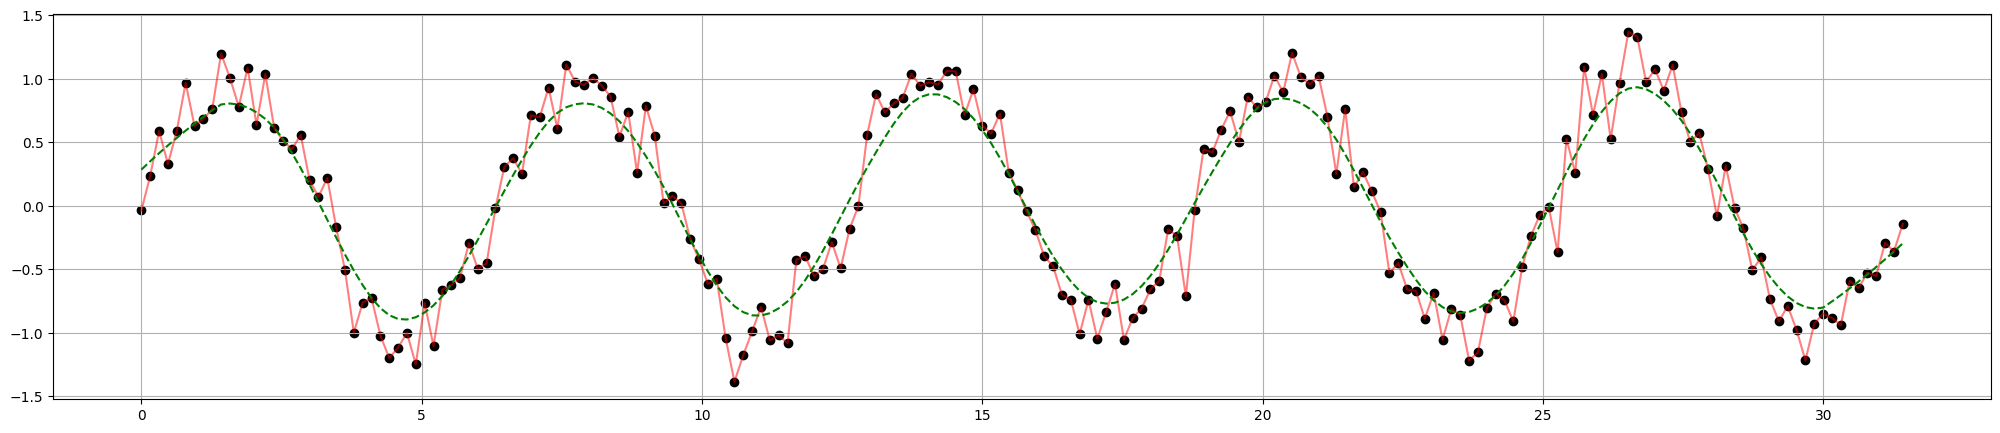

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(x,y, ls='-', color='red', alpha=0.5)
plt.scatter(x,y, marker='o', color='black')
plt.grid()

plt.plot(x, transformed_y, ls = '--', color='green')
plt.show()


In [9]:
! ls ../

bin			    etc     media		      root  tools
boot			    home    mnt			      run   usr
content			    lib     NGC-DL-CONTAINER-LICENSE  sbin  var
cuda-keyring_1.0-1_all.deb  lib32   opt			      srv
datalab			    lib64   proc		      sys
dev			    libx32  python-apt		      tmp
